In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math
import yfinance as yf
import warnings
from polygon import RESTClient
warnings.filterwarnings('ignore')


In [2]:
#load datasets
am_df = pd.read_csv("data/american_stock.csv")
eu_df = pd.read_csv("data/european_index.csv")
rf_df = pd.read_csv("data/FEDFUNDS.csv")
european_index_df = pd.read_csv("data/ndx_historical.csv")


In [3]:
rf_df["DATE"] = pd.to_datetime(rf_df["DATE"], format="%Y-%m-%d")

In [5]:
volatility_intervals = 100
eu_df["date"] = pd.to_datetime(eu_df["date"], format="%Y%m%d")
eu_df["exdate"] = pd.to_datetime(eu_df["exdate"], format="%Y%m%d")
eu_df["rf_join_date"] = pd.to_datetime(eu_df["date"].apply(lambda x: datetime.date(x.year, x.month, 1)))
eu_df["tte"] = eu_df["exdate"] - eu_df["date"]
european_index_df["Date"] = pd.to_datetime(european_index_df["Date"])
european_index_df["volatility"] = european_index_df["Close/Last"].rolling(volatility_intervals).std() / european_index_df["Close/Last"]
eu_df = pd.merge(eu_df, rf_df, left_on="rf_join_date", right_on="DATE")
eu_df = pd.merge(eu_df, european_index_df, left_on="date", right_on="Date")
eu_df = eu_df[["date", "exdate", "symbol", "cp_flag", "strike_price", "best_bid", "best_offer", "tte", "Close/Last", "FEDFUNDS", "volatility"]]
eu_df["modeled_price"] = 0 #temporary placeholder
eu_df["percent_error"] = 0
eu_df.head()

,date,exdate,symbol,cp_flag,strike_price,best_bid,best_offer,tte,Close/Last,FEDFUNDS,volatility,modeled_price,percent_error
0,2015-01-02,2015-01-09,NDX 150109C3100000,C,3100000,1124.9,1134.0,7 days,4230.24,0.11,0.027469,0,0
1,2015-01-02,2015-01-09,NDX 150109C3125000,C,3125000,1099.9,1109.0,7 days,4230.24,0.11,0.027469,0,0
2,2015-01-02,2015-01-09,NDX 150109C3150000,C,3150000,1074.9,1084.0,7 days,4230.24,0.11,0.027469,0,0
3,2015-01-02,2015-01-09,NDX 150109C3175000,C,3175000,1049.9,1059.0,7 days,4230.24,0.11,0.027469,0,0
4,2015-01-02,2015-01-09,NDX 150109C3200000,C,3200000,1024.9,1034.0,7 days,4230.24,0.11,0.027469,0,0


In [4]:
am_df = am_df[["date", "symbol", "exdate", "cp_flag", "strike_price", "best_bid", "best_offer", "exercise_style"]]
am_df["date"] = pd.to_datetime(am_df["date"], format="%Y%m%d")
am_df["exdate"] = pd.to_datetime(am_df["exdate"], format="%Y%m%d")
am_df["tte"] = am_df["exdate"] - am_df["date"]
am_df["rf_join_date"] = pd.to_datetime(am_df["date"].apply(lambda x: datetime.date(x.year, x.month, 1)))
am_df = pd.merge(am_df, rf_df, left_on="rf_join_date", right_on="DATE")
am_df = am_df[["date", "symbol", "exdate", "cp_flag", "strike_price", "best_bid", "best_offer", "exercise_style", "tte", "Close/Last", "FEDFUNDS"]]


KeyError: "['Close/Last'] not in index"

In [6]:
#Current assumptions: risk-neutral, a set volatility and that FED rate is essentially the risk-free rate

def simple_european_binomial_model(n_steps, vol, underlying_price, strike, tte, int_rate, call=True):
    """
    Returns the modeled price of a European options contract. 
    n_steps: number of steps
    vol: volatility (in float)
    underlying_price: initial stock price
    strike: strike price of option
    tte: time to expiration of contract (in days)
    int_rate: risk-free interest rate
    call: boolean True if call, False otherwise
    """
    dt = (tte/365)/n_steps
    u = math.exp(vol*math.sqrt(dt))
    d = 1/u
    p = (math.exp(int_rate*dt)-d)/(u-d)
    
    stock_prices = [] #possible stock prices at the latest time
    options_prices = [] #options values at the respective times
    for i in range(0,n_steps+1):
        stock_prices.append(underlying_price*(u**(n_steps-i))*(d**i))
        if call:
            options_prices.append(max(0,stock_prices[i]-strike))
        else:
            options_prices.append(max(0,strike-stock_prices[i]))
    #combine options data backwards in pairs
    counter = n_steps-1
    while counter > -1:
        for i in range(counter+1):
            price = math.exp(-int_rate*dt)*(p*options_prices[i] + (1-p)*options_prices[i+1])
            options_prices[i] = price
        counter-=1
    return options_prices[0]


In [10]:
eu_df.head(90)

,date,exdate,symbol,cp_flag,strike_price,best_bid,best_offer,tte,Close/Last,FEDFUNDS,volatility,modeled_price,percent_error
0,2015-01-02,2015-01-09,NDX 150109C3100000,C,3100000,1124.90,1134.00,7 days,4230.24,0.11,0.027469,1136.772833,0.010555
1,2015-01-02,2015-01-09,NDX 150109C3125000,C,3125000,1099.90,1109.00,7 days,4230.24,0.11,0.027469,1111.825517,0.010842
2,2015-01-02,2015-01-09,NDX 150109C3150000,C,3150000,1074.90,1084.00,7 days,4230.24,0.11,0.027469,1086.878201,0.011144
3,2015-01-02,2015-01-09,NDX 150109C3175000,C,3175000,1049.90,1059.00,7 days,4230.24,0.11,0.027469,1061.930885,0.011459
4,2015-01-02,2015-01-09,NDX 150109C3200000,C,3200000,1024.90,1034.00,7 days,4230.24,0.11,0.027469,1036.983569,0.011790
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2015-01-02,2015-01-09,NDX 150109C4335000,C,4335000,0.90,2.90,7 days,4230.24,0.11,0.027469,0.000000,1.000000
86,2015-01-02,2015-01-09,NDX 150109C4340000,C,4340000,0.85,2.85,7 days,4230.24,0.11,0.027469,0.000000,1.000000
87,2015-01-02,2015-01-09,NDX 150109C4345000,C,4345000,0.70,2.45,7 days,4230.24,0.11,0.027469,0.000000,1.000000
88,2015-01-02,2015-01-09,NDX 150109C4350000,C,4350000,0.45,1.85,7 days,4230.24,0.11,0.027469,0.000000,1.000000


The model has an accuracy of 2.1393346251803894e-05 over the whole chain.


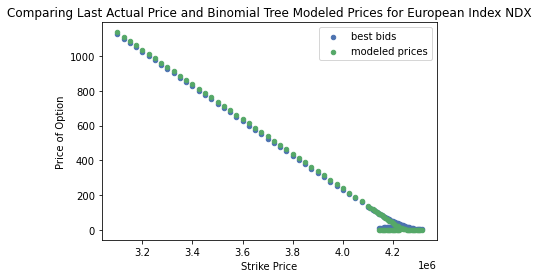

In [7]:
#To test other models, just change the parameters needed, docs will be added later
print("The model has an accuracy of " + str(eu_df["percent_error"].mean()) + " over the whole chain.")
eu_copy = eu_df[eu_df["modeled_price"] >0]

for i in range(0,700): 
  vol = eu_df["volatility"][i]
  stock_price = eu_df["Close/Last"][i]
  strike = eu_df["strike_price"][i]/1000
  tte = eu_df["tte"][i].days
  int_rate = eu_df["FEDFUNDS"][i]
  call = True if eu_df["cp_flag"][i] == 'C' else False
  eu_df["modeled_price"][i] = simple_european_binomial_model(30,vol,stock_price,strike,tte,int_rate,call)
  eu_df["percent_error"][i] = abs((eu_df['best_bid'][i] - eu_df["modeled_price"][i])/eu_df['best_bid'][i])

plt.style.use('seaborn-deep')
plt.scatter(eu_copy['strike_price'][0:100].to_numpy(),eu_copy['best_bid'][0:100].to_numpy(),label="best bids", s=20)
plt.scatter(eu_copy['strike_price'][0:100].to_numpy(),eu_copy["modeled_price"][0:100].to_numpy(),label="modeled prices", s=20)
plt.title('Comparing Last Actual Price and Binomial Tree Modeled Prices for European Index NDX')
plt.ylabel('Price of Option')

plt.xlabel('Strike Price')
ax = plt.axes()
ax.set_facecolor('white')
plt.legend()
plt.show()

In [ ]:
eu_df.head()

,date,exdate,symbol,cp_flag,strike_price,best_bid,best_offer,tte,Close/Last,FEDFUNDS,volatility,modeled_price
0,2015-01-02,2015-01-09,NDX 150109C3100000,C,3100000,1124.9,1134.0,7 days,4230.24,0.11,0.027469,1136.772833
1,2015-01-02,2015-01-09,NDX 150109C3125000,C,3125000,1099.9,1109.0,7 days,4230.24,0.11,0.027469,1111.825517
2,2015-01-02,2015-01-09,NDX 150109C3150000,C,3150000,1074.9,1084.0,7 days,4230.24,0.11,0.027469,1086.878201
3,2015-01-02,2015-01-09,NDX 150109C3175000,C,3175000,1049.9,1059.0,7 days,4230.24,0.11,0.027469,1061.930885
4,2015-01-02,2015-01-09,NDX 150109C3200000,C,3200000,1024.9,1034.0,7 days,4230.24,0.11,0.027469,1036.983569


In [65]:
#Current assumptions: #Current assumptions: risk-neutral, a set volatility and that FED rate is essentially the risk-free rate
def american_binomial_model(n_steps, vol, underlying_price, strike, tte, int_rate, call=True):
    """
    Returns the modeled price of an American options contract. 
    n_steps: number of steps
    vol: volatility (in float)
    underlying_price: initial stock price
    strike: strike price of option
    tte: time to expiration of contract (in days)
    int_rate: risk-free interest rate
    call: boolean True if call, False otherwise
    """
    dt = (tte/365)/n_steps
    u = math.exp(vol*math.sqrt(dt))
    d = 1/u
    p = (math.exp(int_rate*dt)-d)/(u-d)
    #initialize arrays to hold stock/options_payoff values 
    stock_prices = [0]*(n_steps+1)
    for i in range(1,n_steps+1):
        stock_prices[i]= [0]*(i+1)
    options_payoff = stock_prices.copy()
    stock_prices[0] = underlying_price
    #calculate possible stock prices 
    for i in range(1,n_steps+1):
        for j in range(i+1):
            stock_prices[i][j] = underlying_price*(u**(i-j))*(d**j)
            
    #calculate options payoffs at the respective times depending on stock prices
    for i in range(1,n_steps+1):
        for j in range(i+1):
            if call:
                options_payoff[i][j] = max(0,stock_prices[i][j]-strike)
            else:
                options_payoff[i][j] = max(0,strike-stock_prices[i][j])
    
    #calculate max(options payoff if exercised early, option value)
    option_value = options_payoff[:]
    for i in range(n_steps-1,0,-1):
        for j in range(i+1):
            option_value[i][j] = max(options_payoff[i][j], (math.exp(-int_rate * dt)*(p * option_value[i+1][j] + (1-p)*option_value[i+1][j+1])))  
    return math.exp(-int_rate*dt)*(p*option_value[1][0] + (1-p)*option_value[1][1])
        # Calculate option values at earlier times

The model has an accuracy of 0.47530326119905714 over the whole chain.
The model has an accuracy of 0.30289881415327924 over the middle 50% of the options chain.


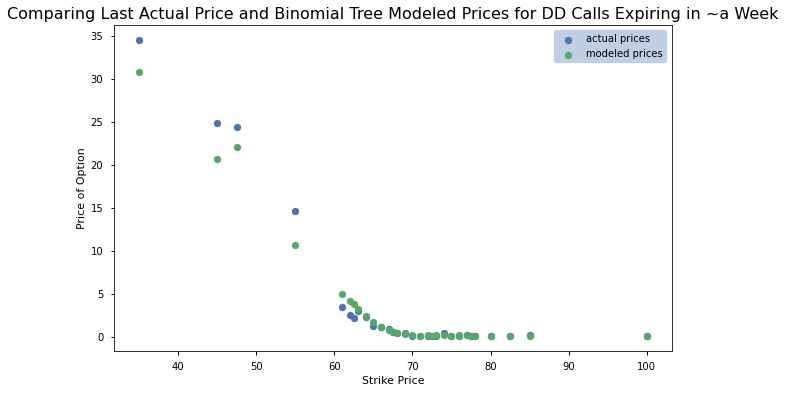

The model has an accuracy of 0.17562032370294664 over the whole chain.
The model has an accuracy of 0.08440253660652353 over the middle 50% of the options chain.


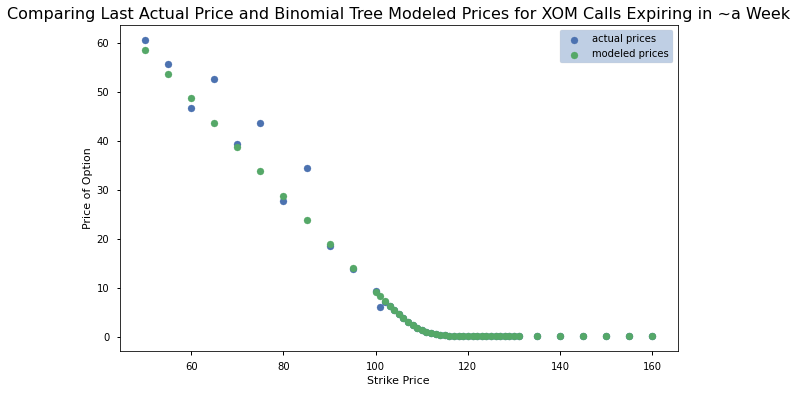

The model has an accuracy of 0.540724487635327 over the whole chain.
The model has an accuracy of 0.6946348464924733 over the middle 50% of the options chain.


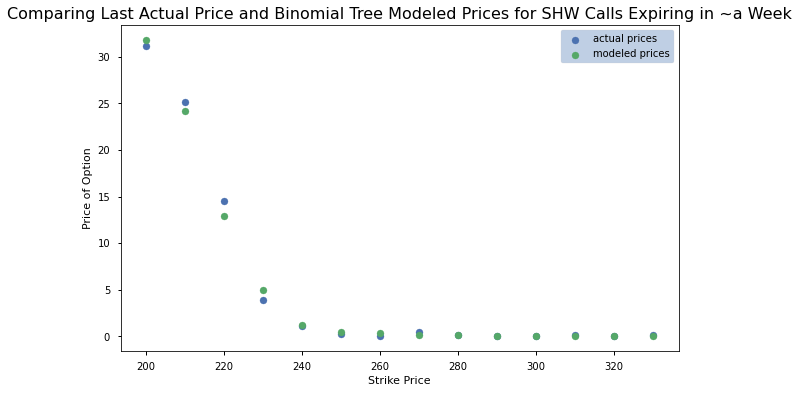

The model has an accuracy of 0.1603819281559243 over the whole chain.
The model has an accuracy of 0.08004245096179773 over the middle 50% of the options chain.


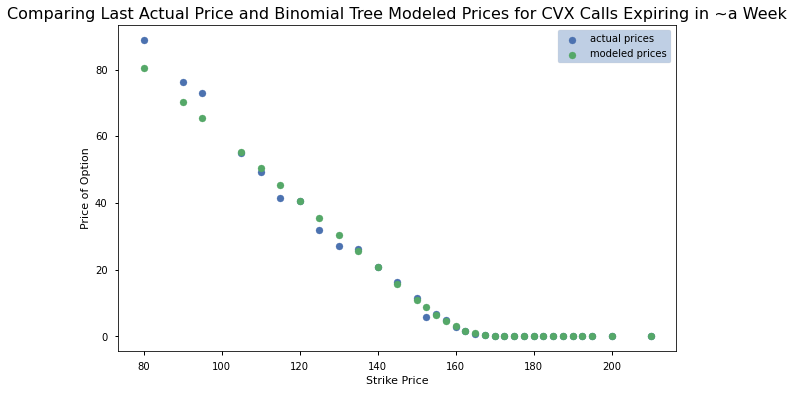

The model has an accuracy of 0.20973078020180067 over the whole chain.
The model has an accuracy of 0.06279988933946973 over the middle 50% of the options chain.


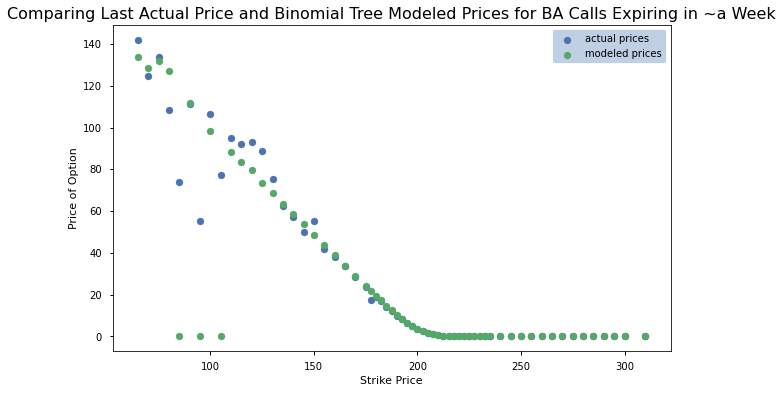

The model has an accuracy of 0.5055586049585236 over the whole chain.
The model has an accuracy of 0.3104908834712829 over the middle 50% of the options chain.


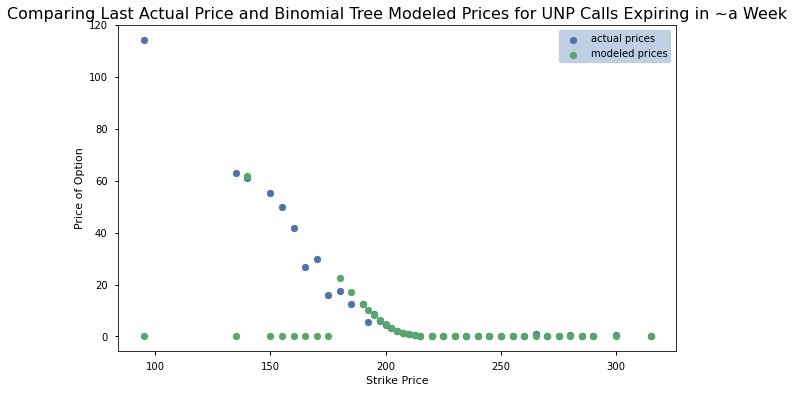

The model has an accuracy of 0.14097649044010566 over the whole chain.
The model has an accuracy of 0.09735786052645916 over the middle 50% of the options chain.


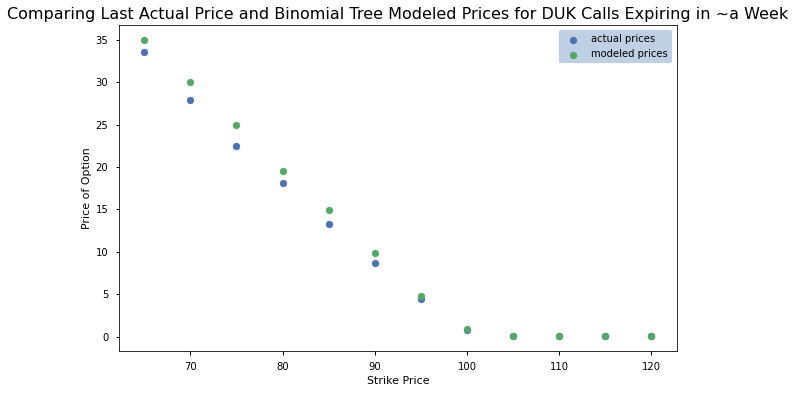

The model has an accuracy of 0.25876787288961894 over the whole chain.
The model has an accuracy of 0.16803317802994538 over the middle 50% of the options chain.


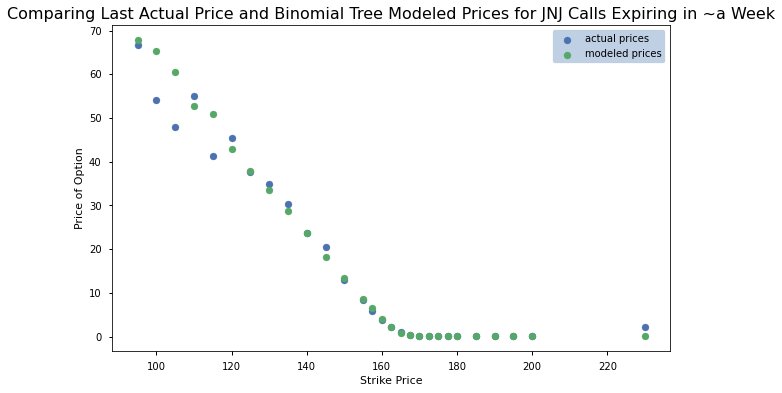

The model has an accuracy of 0.4177466070962988 over the whole chain.
The model has an accuracy of 0.08397958989038493 over the middle 50% of the options chain.


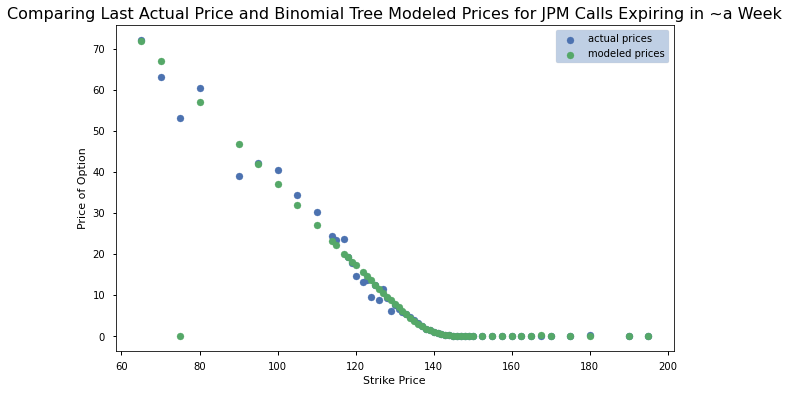

The model has an accuracy of 0.23013602410040046 over the whole chain.
The model has an accuracy of 0.08502178140763932 over the middle 50% of the options chain.


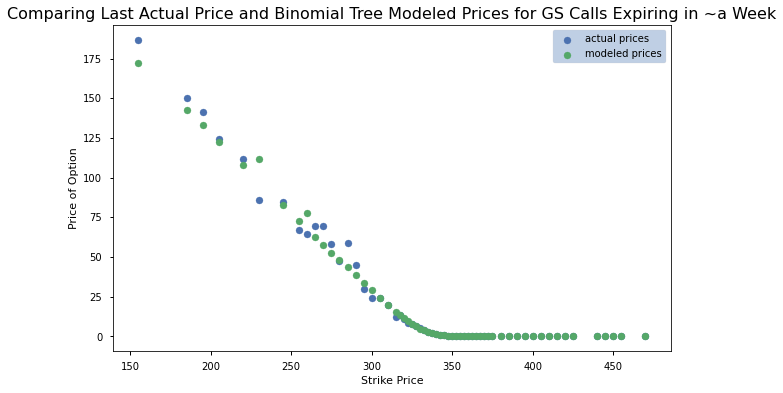

The model has an accuracy of 0.1232703507156997 over the whole chain.
The model has an accuracy of 0.031023025812064495 over the middle 50% of the options chain.


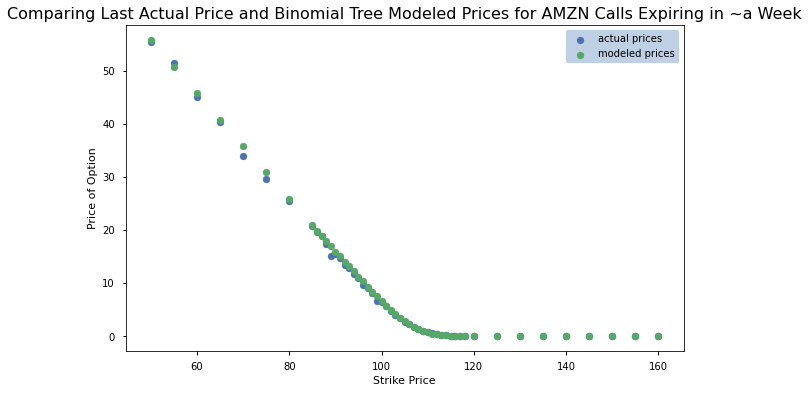

The model has an accuracy of 0.5956874893473676 over the whole chain.
The model has an accuracy of 0.05656919964359338 over the middle 50% of the options chain.


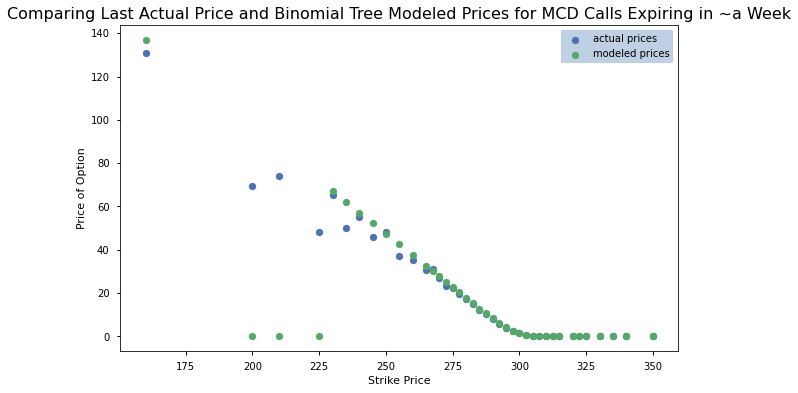

The model has an accuracy of 0.3489156715758289 over the whole chain.
The model has an accuracy of 0.0337347478889863 over the middle 50% of the options chain.


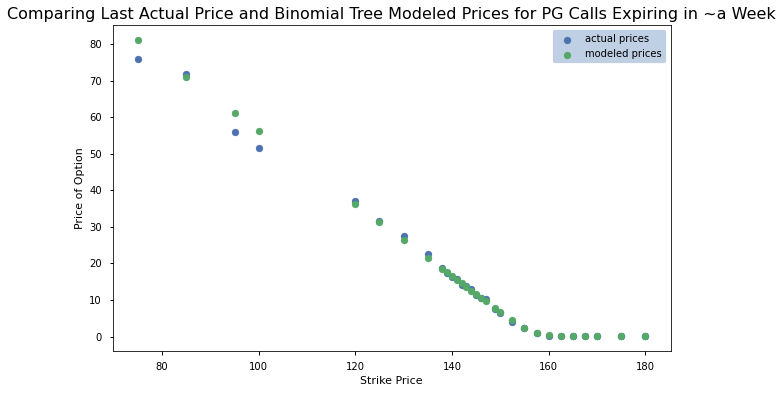

The model has an accuracy of 0.25477851500114584 over the whole chain.
The model has an accuracy of 0.10399981072667266 over the middle 50% of the options chain.


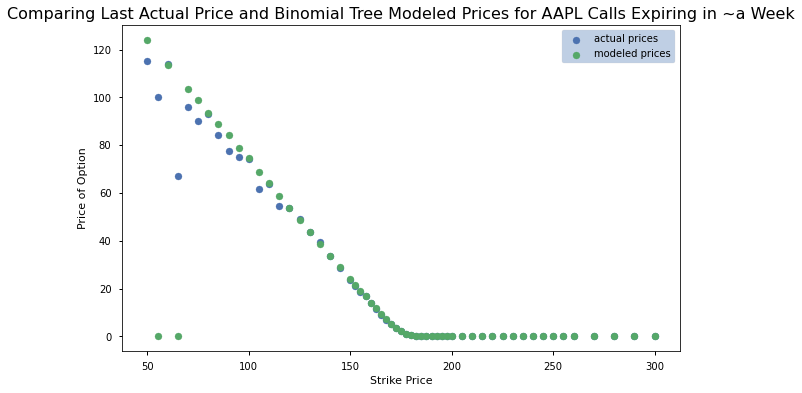

The model has an accuracy of 0.41850094912664154 over the whole chain.
The model has an accuracy of 0.05443289169801459 over the middle 50% of the options chain.


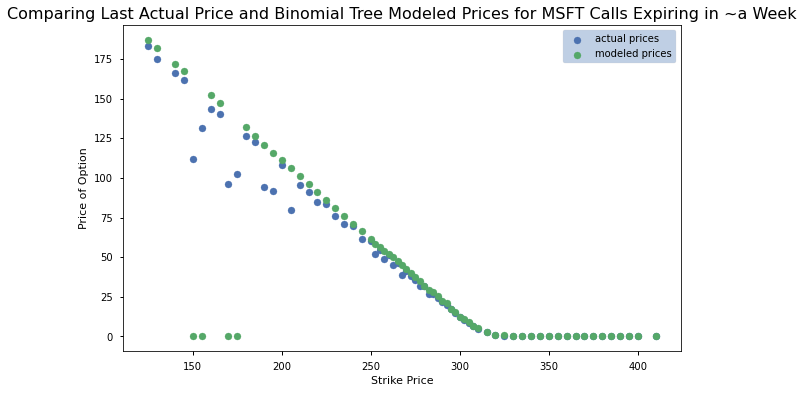

The model has an accuracy of 1.5719227281241828 over the whole chain.
The model has an accuracy of 0.13351236657753732 over the middle 50% of the options chain.


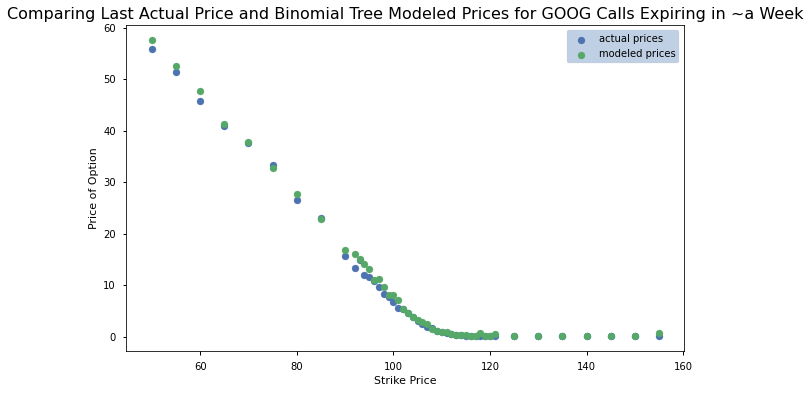

The model has an accuracy of 0.5081907372804314 over the whole chain.
The model has an accuracy of 0.1321302408600915 over the middle 50% of the options chain.


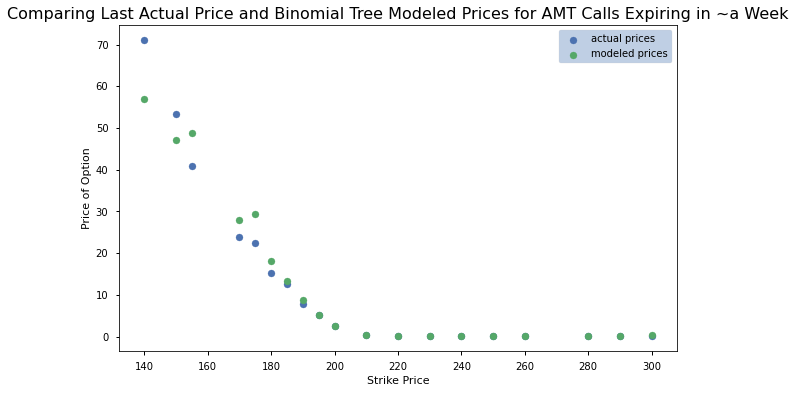

In [94]:
int_rate = 0.0344 #risk free interest rate today
def compare(ticker,date):
    """
    Generates plots comparing the modeled prices from the Binomial Model Tree to 
    actual stock data.
    ticker: ticker for the stock
    date: options expiration date
    """
    formatted_date = datetime.date(int(date[0:4]),int(date[5:7]),int(date[8::]))
    tte = formatted_date - datetime.date.today()
    stock = yf.Ticker(ticker)
    stock_price = stock.info['currentPrice']
    opt_chain = stock.option_chain(date)
    calls = opt_chain.calls
    calls["modeled_price"] = 0
    calls["percent_error"] = 0
    for i in range(0,calls.shape[0]):
        calculated_price = american_binomial_model(100,calls['impliedVolatility'][i],stock_price,calls['strike'][i],tte.days,int_rate,True)
        calls["modeled_price"][i] = calculated_price if (calculated_price < 2000 and calculated_price > 0) else 0
        calls["percent_error"][i] = abs((calls['lastPrice'][i] - calls["modeled_price"][i])/calls['lastPrice'][i])
    print("The model has an accuracy of " + str(calls["percent_error"].mean()) + " over the whole chain.")
    bottom = calls.shape[0]//4
    top = bottom*3
    print("The model has an accuracy of " + str(calls["percent_error"][bottom:top].mean()) + " over the middle 50% of the options chain.")
    plt.figure(figsize=(10,6))
    plt.style.use("seaborn-deep")
    plt.scatter(calls['strike'].to_numpy(),calls['lastPrice'].to_numpy(),label="actual prices")
    plt.scatter(calls['strike'].to_numpy(),calls["modeled_price"].to_numpy(),label="modeled prices")
    plt.title('Comparing Last Actual Price and Binomial Tree Modeled Prices for ' + ticker + ' Calls Expiring in ~a Week', fontsize = 16)
    plt.ylabel('Price of Option')
    plt.xlabel('Strike Price')
    ax =plt.axes()
    ax.set_facecolor("white")
    plt.legend()
    plt.show()
    return 

stocks = {
    "DD":'2023-05-19', #Energy Sector
    "XOM":'2023-05-19', #Energy Sector
    "SHW":'2023-05-19', #Materials Sector
    "CVX":'2023-05-19', #Materials Sector
    "BA":'2023-05-19', #Industrial Sector
    "UNP":'2023-05-19', #Industrial Sector
    "DUK": '2023-05-19', #Healthcare
    "JNJ": '2023-05-19', #Healthcare
    "JPM": '2023-05-19', #Financial
    "GS" :'2023-05-19', #Financial
    "AMZN" :'2023-05-19', #Consumer Discretionary Sector
    "MCD" :'2023-05-19', #Consumer Discretionary Sector
    "PG" :'2023-05-19',#Consume Staples Sector
    "AAPL":'2023-05-19', #Tech Sector
    "MSFT": '2023-05-19',#Tech Sector
    "GOOG":'2023-05-19', #Communication Sector
    "AMT": '2023-05-19', #Real Estate
    }
for key in stocks:
    compare(key,'2023-05-19')

The model has an accuracy of 0.2797785696861768 over the whole chain.
The model has an accuracy of 0.2259863982924638 over the middle 50% of the options chain.


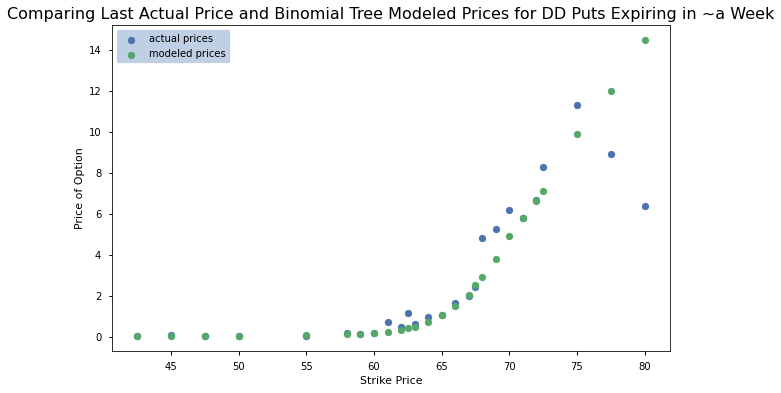

The model has an accuracy of 0.25357136690358567 over the whole chain.
The model has an accuracy of 0.09122405173254743 over the middle 50% of the options chain.


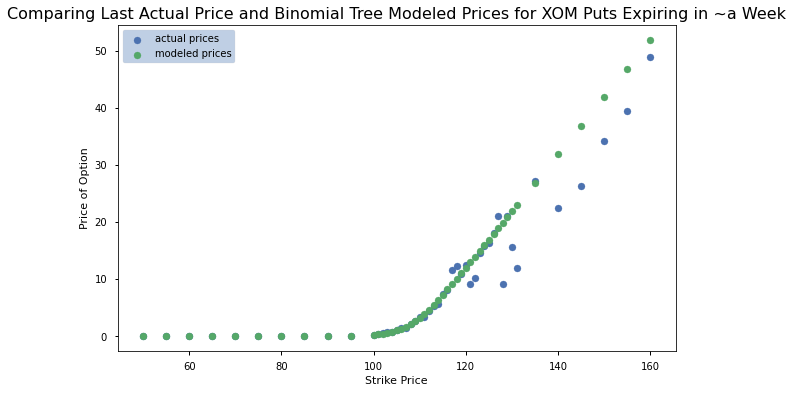

The model has an accuracy of 0.40731758162580994 over the whole chain.
The model has an accuracy of 0.47211160325652246 over the middle 50% of the options chain.


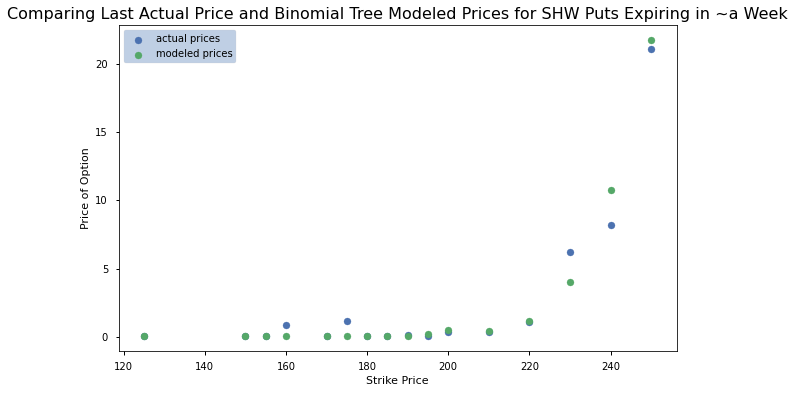

The model has an accuracy of 0.24350729392405351 over the whole chain.
The model has an accuracy of 0.0991686256769477 over the middle 50% of the options chain.


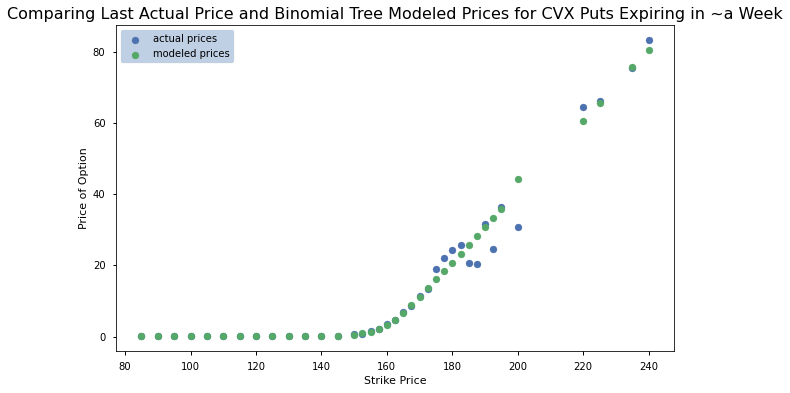

The model has an accuracy of 0.3451610256563828 over the whole chain.
The model has an accuracy of 0.1613380785018211 over the middle 50% of the options chain.


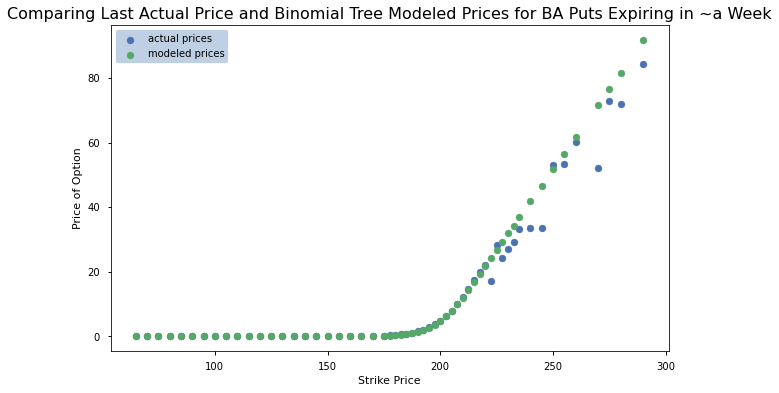

The model has an accuracy of 0.33566751417790375 over the whole chain.
The model has an accuracy of 0.3166090204053854 over the middle 50% of the options chain.


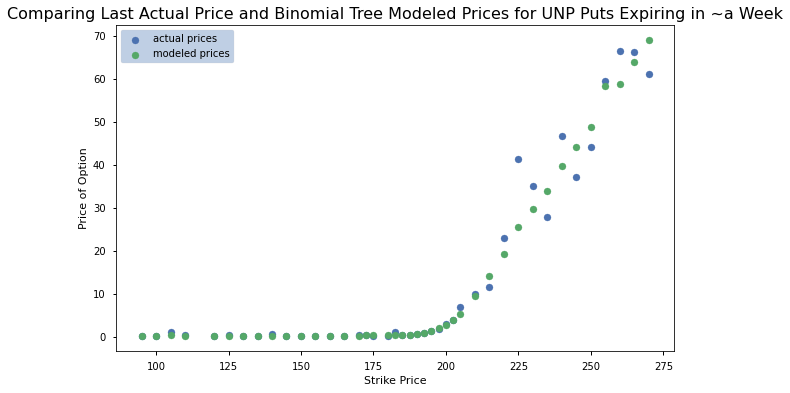

The model has an accuracy of 0.26040073025156274 over the whole chain.
The model has an accuracy of 0.16500553133834595 over the middle 50% of the options chain.


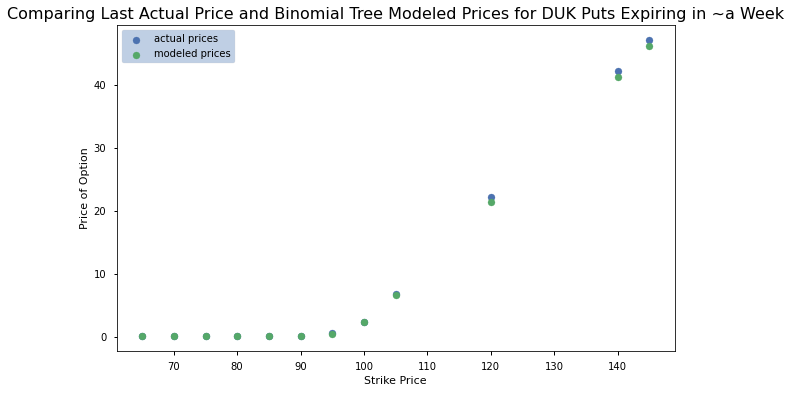

The model has an accuracy of 0.476729928658146 over the whole chain.
The model has an accuracy of 0.30781065954237585 over the middle 50% of the options chain.


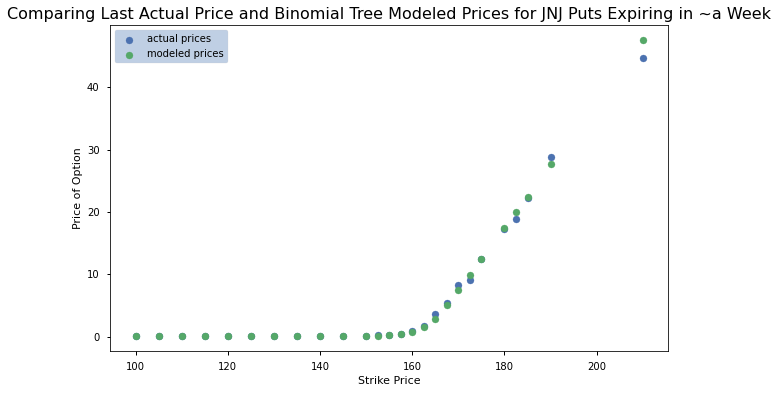

The model has an accuracy of 0.24599925260271835 over the whole chain.
The model has an accuracy of 0.11000993815805123 over the middle 50% of the options chain.


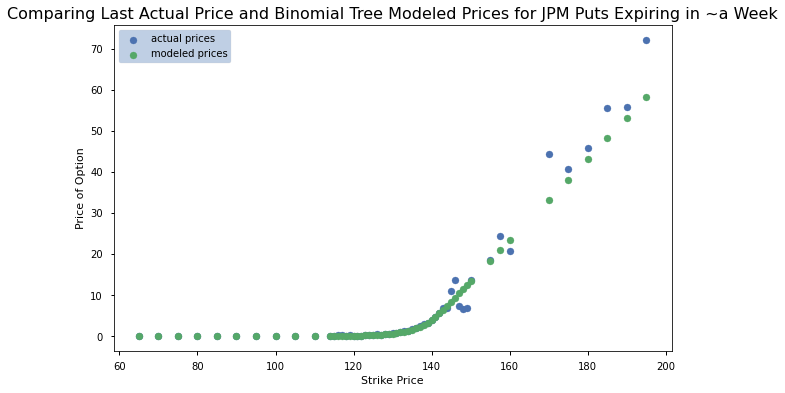

The model has an accuracy of 0.3495184655512351 over the whole chain.
The model has an accuracy of 0.25569488443990773 over the middle 50% of the options chain.


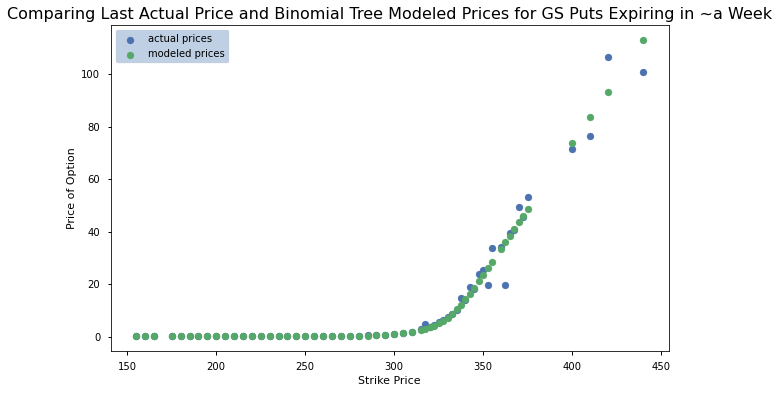

The model has an accuracy of 0.15757417904123508 over the whole chain.
The model has an accuracy of 0.09305034202365749 over the middle 50% of the options chain.


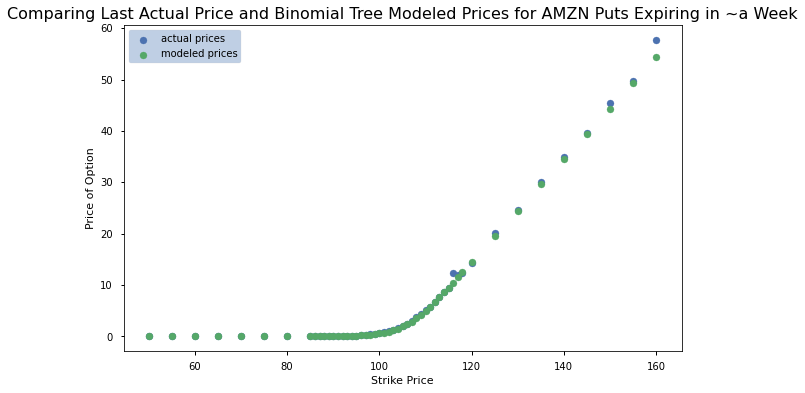

The model has an accuracy of 0.3555537700982765 over the whole chain.
The model has an accuracy of 0.3061967336136402 over the middle 50% of the options chain.


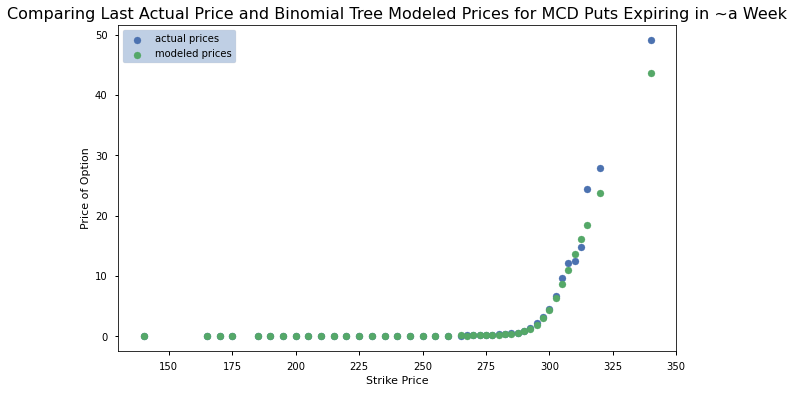

The model has an accuracy of 0.31157487065757383 over the whole chain.
The model has an accuracy of 0.3666190953267968 over the middle 50% of the options chain.


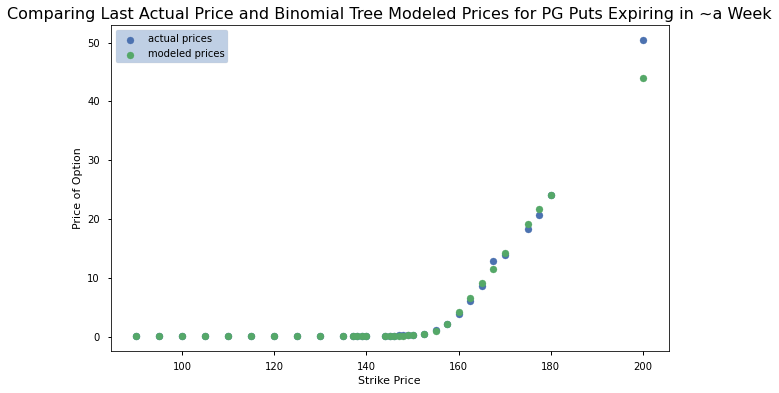

The model has an accuracy of 0.29175115124315615 over the whole chain.
The model has an accuracy of 0.17123713474345026 over the middle 50% of the options chain.


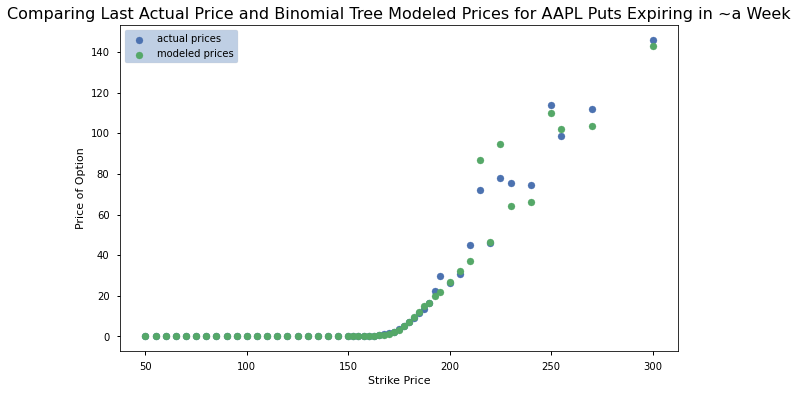

The model has an accuracy of 0.4632371107246618 over the whole chain.
The model has an accuracy of 0.5042613009970461 over the middle 50% of the options chain.


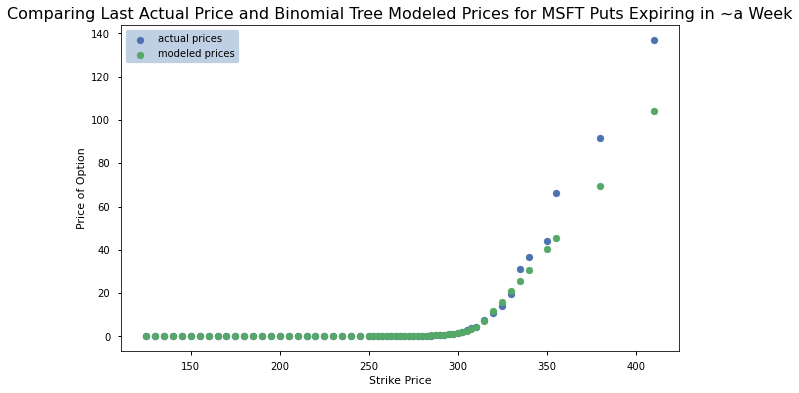

The model has an accuracy of 4.13053040977344 over the whole chain.
The model has an accuracy of 0.16478404628190135 over the middle 50% of the options chain.


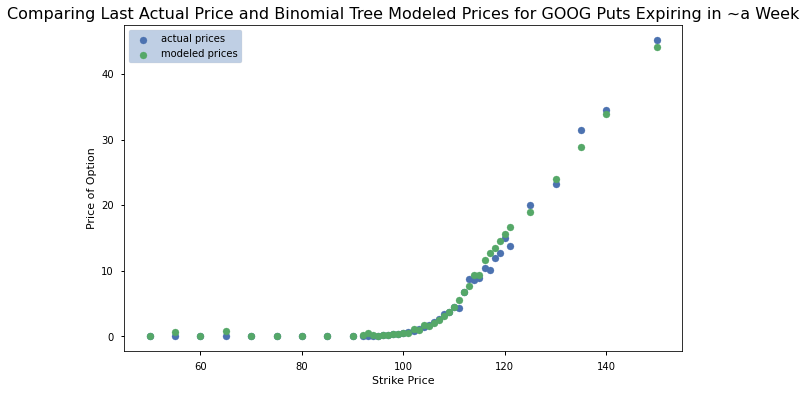

The model has an accuracy of 0.39874806156108195 over the whole chain.
The model has an accuracy of 0.2632556399042526 over the middle 50% of the options chain.


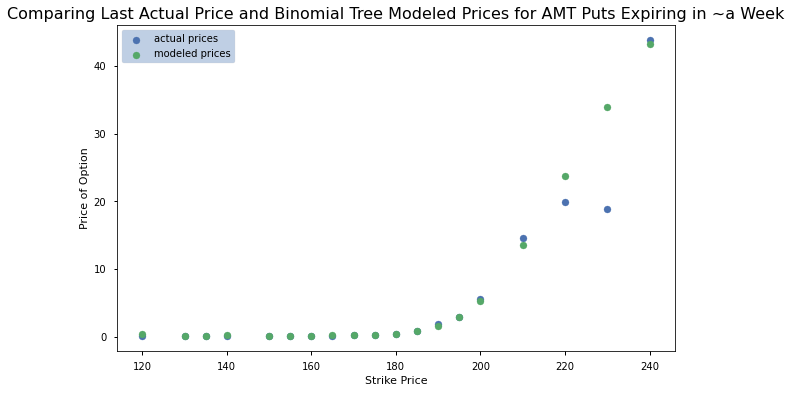

In [100]:
int_rate = 0.0344 #risk free interest rate today
def compare(ticker,date):
    """
    Generates plots comparing the modeled prices from the Binomial Model Tree to 
    actual stock data.
    ticker: ticker for the stock
    date: options expiration date
    """
    formatted_date = datetime.date(int(date[0:4]),int(date[5:7]),int(date[8::]))
    tte = formatted_date - datetime.date.today()
    stock = yf.Ticker(ticker)
    stock_price = stock.info['currentPrice']
    opt_chain = stock.option_chain(date)
    puts = opt_chain.puts
    puts["modeled_price"] = 0
    puts["percent_error"] = 0
    for i in range(0,puts.shape[0]):
        calculated_price = american_binomial_model(100,puts['impliedVolatility'][i],stock_price,puts['strike'][i],tte.days,int_rate,False)
        puts["modeled_price"][i] = calculated_price if (calculated_price < 2000 and calculated_price > 0) else 0
        puts["percent_error"][i] = abs((puts['lastPrice'][i] - puts["modeled_price"][i])/puts['lastPrice'][i])
    print("The model has an accuracy of " + str(puts["percent_error"].mean()) + " over the whole chain.")
    bottom = puts.shape[0]//4
    top = bottom*3
    print("The model has an accuracy of " + str(puts["percent_error"][bottom:top].mean()) + " over the middle 50% of the options chain.")
    plt.figure(figsize=(10,6))
    plt.style.use("seaborn-deep")
    plt.scatter(puts['strike'].to_numpy(),puts['lastPrice'].to_numpy(),label="actual prices")
    plt.scatter(puts['strike'].to_numpy(),puts["modeled_price"].to_numpy(),label="modeled prices")
    plt.title('Comparing Last Actual Price and Binomial Tree Modeled Prices for ' + ticker + ' Puts Expiring in ~a Week', fontsize = 16)
    plt.ylabel('Price of Option')
    plt.xlabel('Strike Price')
    ax =plt.axes()
    ax.set_facecolor("white")
    plt.legend()
    plt.show()
    return 

stocks = {
    "DD":'2023-05-19', #Energy Sector
    "XOM":'2023-05-19', #Energy Sector
    "SHW":'2023-05-19', #Materials Sector
    "CVX":'2023-05-19', #Materials Sector
    "BA":'2023-05-19', #Industrial Sector
    "UNP":'2023-05-19', #Industrial Sector
    "DUK": '2023-05-19', #Healthcare
    "JNJ": '2023-05-19', #Healthcare
    "JPM": '2023-05-19', #Financial
    "GS" :'2023-05-19', #Financial
    "AMZN" :'2023-05-19', #Consumer Discretionary Sector
    "MCD" :'2023-05-19', #Consumer Discretionary Sector
    "PG" :'2023-05-19',#Consume Staples Sector
    "AAPL":'2023-05-19', #Tech Sector
    "MSFT": '2023-05-19',#Tech Sector
    "GOOG":'2023-05-19', #Communication Sector
    "AMT": '2023-05-19', #Real Estate
    }
for key in stocks:
    compare(key,'2023-05-19')

The model has an accuracy of 0.4632371107246618 over the whole chain.
The model has an accuracy of 0.5042613009970461 over the middle 50% of the options chain.


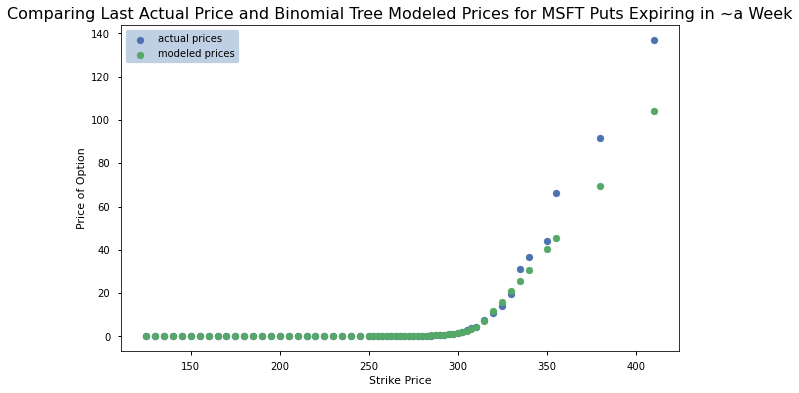

The model has an accuracy of 1.0976076985580312 over the whole chain.
The model has an accuracy of 0.1731247402183805 over the middle 50% of the options chain.


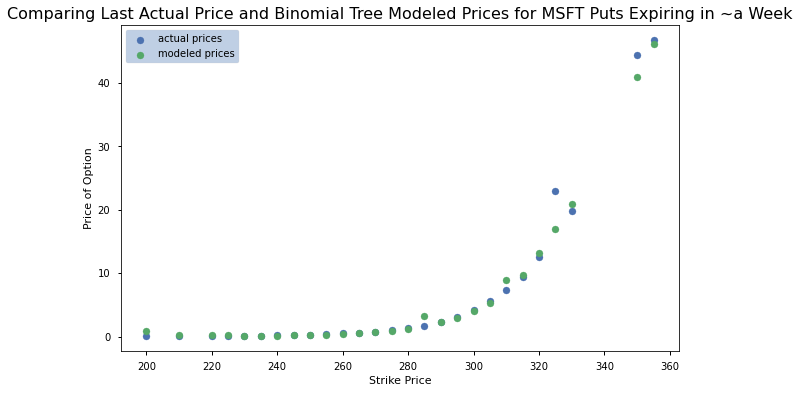

The model has an accuracy of 0.15540281570775002 over the whole chain.
The model has an accuracy of 0.13455319336798915 over the middle 50% of the options chain.


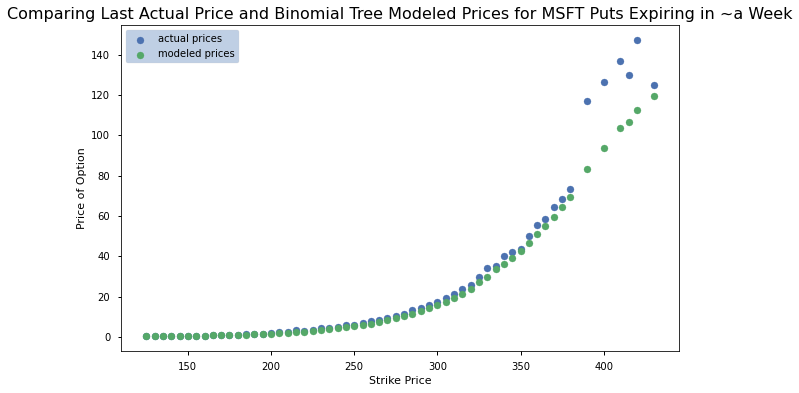

The model has an accuracy of 0.1695424187198155 over the whole chain.
The model has an accuracy of 0.11707671976921216 over the middle 50% of the options chain.


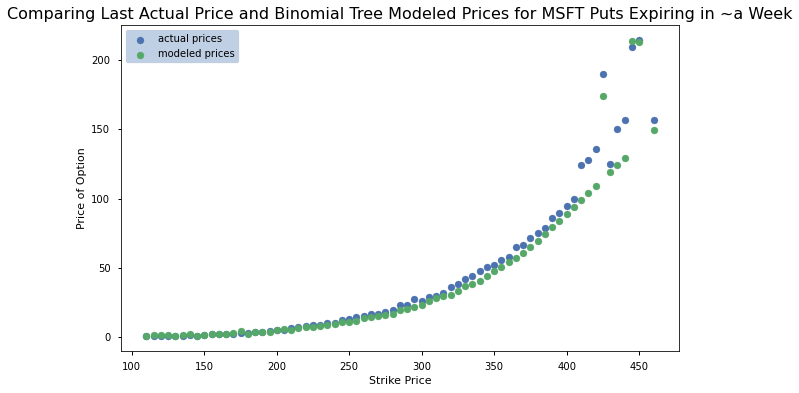

In [106]:
compare("MSFT","2023-05-19")
compare("MSFT","2023-06-09")
compare("MSFT","2023-11-17")
compare("MSFT","2024-06-21")